# Breweries — Bronze/Silver/Gold Analysis (MinIO + Spark)

This notebook connects to your **MinIO** data lake using Spark (**S3A**) and explores the
**Bronze**, **Silver**, and **Gold** layers created by the Airflow pipeline.

It will:
- Discover the latest `ingestion_date` automatically (you can override it).
- Read **Bronze** JSON (paged raw API responses)
- Read **Silver** Parquet (cleaned & typed), partitioned by `country` and `state`.
- Read **Gold** aggregates
- Show counts, schemas, samples, and simple charts.


## Setting variables

In [1]:
import os
from datetime import datetime
from pyspark.sql import SparkSession, functions as F

MINIO_ENDPOINT_URL = os.getenv("MINIO_ENDPOINT_URL", "http://minio:9000")
MINIO_SECURE = "true" if MINIO_ENDPOINT_URL.startswith("https://") else "false"

MINIO_ACCESS_KEY = os.getenv("MINIO_ROOT_USER")
MINIO_SECRET_KEY = os.getenv("MINIO_ROOT_PASSWORD")

BRONZE_BUCKET = os.getenv("BRONZE_BUCKET", "bronze")
SILVER_BUCKET = os.getenv("SILVER_BUCKET", "silver")
GOLD_BUCKET   = os.getenv("GOLD_BUCKET",   "gold")
DATASET_NAME  = os.getenv("DATASET_NAME", "breweries")
# INGESTION_DATE = '2025-08-15'

ACCESS_KEY = os.getenv("MINIO_ROOT_USER")
SECRET_KEY = os.getenv("MINIO_ROOT_PASSWORD")

if not ACCESS_KEY or not SECRET_KEY:
    raise RuntimeError("Credenciais não encontradas em AWS_ACCESS_KEY_ID/AWS_SECRET_ACCESS_KEY (ou MINIO_ROOT_*).")

print("Endpoint:", MINIO_ENDPOINT_URL)
print("Buckets :", BRONZE_BUCKET, SILVER_BUCKET, GOLD_BUCKET)
print("Dataset :", DATASET_NAME)

Endpoint: http://minio:9000
Buckets : bronze silver gold
Dataset : breweries


## Create Spark Session

In [2]:
builder = (
    SparkSession.builder.appName("Breweries MinIO Analysis")
    .config("spark.sql.session.timeZone", "UTC")
    # S3A / MinIO conf
    .config("spark.hadoop.fs.s3a.endpoint", MINIO_ENDPOINT_URL)
    .config("spark.hadoop.fs.s3a.path.style.access", "true")
    .config("spark.hadoop.fs.s3a.connection.ssl.enabled", MINIO_SECURE)
    .config("spark.hadoop.fs.s3a.access.key", MINIO_ACCESS_KEY)
    .config("spark.hadoop.fs.s3a.secret.key", MINIO_SECRET_KEY)
)

builder = (
    builder
    .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension")
    .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog")
)

spark = builder.getOrCreate()
spark


## Get lastest ingestion date

In [3]:
def latest_ingestion_date(bucket: str, dataset: str) -> str:
    """
    Lista s3a://<bucket>/<dataset>/, procura diretórios ingestion_date=YYYY-MM-DD
    e retorna a maior data (string).
    """
    jvm = spark._jvm
    URI = jvm.java.net.URI
    Path = jvm.org.apache.hadoop.fs.Path
    FileSystem = jvm.org.apache.hadoop.fs.FileSystem

    base = f"s3a://{bucket}/{dataset}/"
    fs = FileSystem.get(URI(base), spark._jsc.hadoopConfiguration())
    base_path = Path(base)

    if not fs.exists(base_path):
        raise FileNotFoundError(f"{base} not found")

    dates = []
    for st in fs.listStatus(base_path):
        name = st.getPath().getName()  # exemplo: "ingestion_date=2025-08-15"
        if name.startswith("ingestion_date="):
            dates.append(name.split("=", 1)[1])

    if not dates:
        raise FileNotFoundError(f"Nenhuma partição ingestion_date=* em {base}")
    return sorted(dates)[-1]

INGESTION_DATE = latest_ingestion_date(BRONZE_BUCKET, DATASET_NAME)
print(f"Using ingestion_date: {INGESTION_DATE}")

Using ingestion_date: 2025-08-15


## Bronze — Raw JSON

In [4]:
from pyspark.sql import functions as F  # se ainda não importou

base = f"s3a://{BRONZE_BUCKET}/{DATASET_NAME}"
bronze_glob = f"{base}/ingestion_date=*/page=*.json"

# Read all files and creates a column 'ingestion_date'
bronze_all = (
    spark.read
         .option("multiLine", "true")   # cada página é um array JSON
         .option("basePath", base)      # para o Spark descobrir a partição 'ingestion_date'
         .json(bronze_glob)
)

# Find out the most recent partition
latest_row = bronze_all.select(F.max("ingestion_date").alias("d")).first()
latest_date = latest_row["d"] if latest_row else None
if latest_date is None:
    raise FileNotFoundError(f"Nenhuma partição ingestion_date=* encontrada em {base}")

# Get the most recent partition
bronze_df = bronze_all.filter(F.col("ingestion_date") == latest_date)

print("Latest ingestion_date:", latest_date, "| rows:", bronze_df.count())
bronze_df.printSchema()
bronze_df.show(5, truncate=False)

Latest ingestion_date: 2025-08-15 | rows: 8408
root
 |-- address_1: string (nullable = true)
 |-- address_2: string (nullable = true)
 |-- address_3: string (nullable = true)
 |-- brewery_type: string (nullable = true)
 |-- city: string (nullable = true)
 |-- country: string (nullable = true)
 |-- id: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- name: string (nullable = true)
 |-- phone: string (nullable = true)
 |-- postal_code: string (nullable = true)
 |-- state: string (nullable = true)
 |-- state_province: string (nullable = true)
 |-- street: string (nullable = true)
 |-- website_url: string (nullable = true)
 |-- ingestion_date: date (nullable = true)

+-----------------------+----------+---------+------------+----------------+-------------+------------------------------------+---------------+---------------+---------------------------------+-------------+-----------+-------------+--------------+------------------

## Silver — Cleaned Parquet (partitioned by country/state)

In [5]:

silver_path = f"s3a://{SILVER_BUCKET}/{DATASET_NAME}/ingestion_date={INGESTION_DATE}"
print("Reading Silver from:", silver_path)
silver_df = spark.read.parquet(silver_path)
print("Silver count:", silver_df.count())
silver_df.printSchema()
silver_df.show(5, truncate=False)


Reading Silver from: s3a://silver/breweries/ingestion_date=2025-08-15
Silver count: 8408
root
 |-- id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- brewery_type: string (nullable = true)
 |-- street: string (nullable = true)
 |-- city: string (nullable = true)
 |-- postal_code: string (nullable = true)
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- phone: string (nullable = true)
 |-- website_url: string (nullable = true)
 |-- country: string (nullable = true)
 |-- state: string (nullable = true)

+------------------------------------+-------------------------+------------+-------------------+---------+-----------+------------+-----------+----------+------------------------------+-------------+----------+
|id                                  |name                     |brewery_type|street             |city     |postal_code|longitude   |latitude   |phone     |website_url                   |country      |state     |
+------------

### Charts from Silver

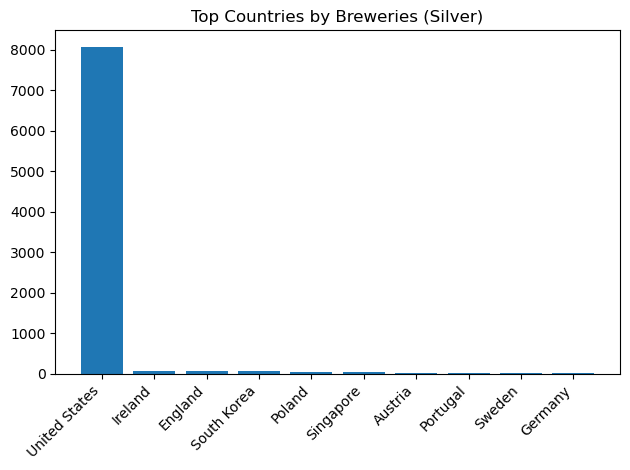

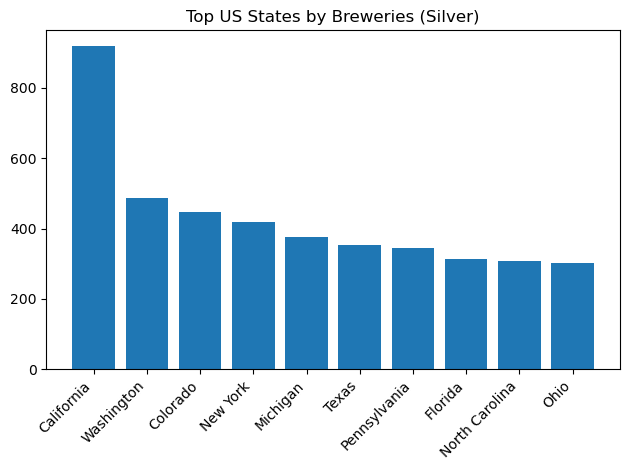

In [6]:
import matplotlib.pyplot as plt

# Top countries by brewery count
top_countries = (
    silver_df.groupBy("country").count()
    .orderBy(F.desc("count"))
    .limit(10)
    .toPandas()
)

plt.figure()
plt.bar(top_countries["country"], top_countries["count"])
plt.title("Top Countries by Breweries (Silver)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Top US states (if country field has 'United States')
us_states = (
    silver_df.where(F.col("country") == "United States")
    .groupBy("state").count()
    .orderBy(F.desc("count"))
    .limit(10)
    .toPandas()
)

if not us_states.empty:
    plt.figure()
    plt.bar(us_states["state"], us_states["count"])
    plt.title("Top US States by Breweries (Silver)")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print("No US data found to plot states.")


## Gold — Aggregates (Delta preferred, Parquet fallback)

In [7]:
from pyspark.sql.utils import AnalysisException

gold_delta_path = f"s3a://{GOLD_BUCKET}/breweries_agg/ingestion_date={INGESTION_DATE}"
gold_root_path  = f"s3a://{GOLD_BUCKET}/breweries_agg"

gold_df = None
read_mode = None

gold_df = spark.read.format("delta").load(gold_delta_path)
read_mode = f"delta @ {gold_delta_path}"


if gold_df is not None:
    print("Gold read mode:", read_mode)
    print("Gold count:", gold_df.count())
    gold_df.printSchema()
    gold_df.show(10, truncate=False)


Gold read mode: delta @ s3a://gold/breweries_agg/ingestion_date=2025-08-15
Gold count: 412
root
 |-- country: string (nullable = true)
 |-- state: string (nullable = true)
 |-- brewery_type: string (nullable = true)
 |-- breweries_count: long (nullable = true)

+-------------+-----------+------------+---------------+
|country      |state      |brewery_type|breweries_count|
+-------------+-----------+------------+---------------+
|United States|Florida    |micro       |190            |
|United States|Florida    |large       |4              |
|United States|Florida    |contract    |6              |
|United States|Florida    |regional    |5              |
|United States|Florida    |brewpub     |65             |
|United States|Florida    |proprietor  |4              |
|United States|Florida    |planning    |38             |
|United States|Connecticut|micro       |48             |
|United States|Connecticut|regional    |2              |
|United States|Connecticut|contract    |5             

### Charts from Gold (if available)

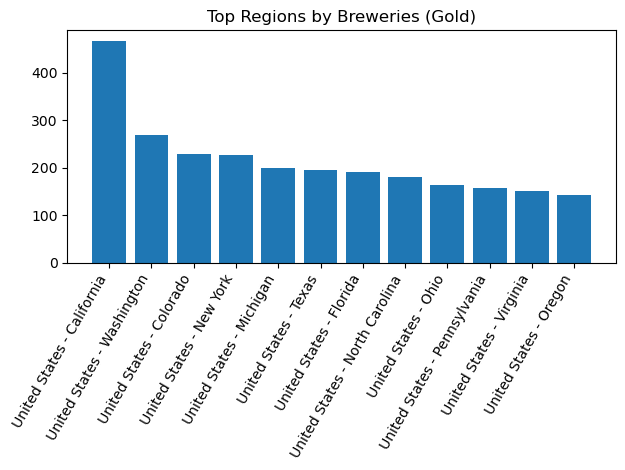

In [8]:
if gold_df is not None and "breweries_count" in gold_df.columns:
    top_gold = gold_df.orderBy(F.desc("breweries_count")).limit(15).toPandas()
    if not top_gold.empty:
        plt.figure()
        labels = (
            top_gold[["country", "state"]]
            .fillna("Unknown")
            .agg(lambda r: f"{r['country']} - {r['state']}", axis=1)
        )
        plt.bar(labels, top_gold["breweries_count"])
        plt.title("Top Regions by Breweries (Gold)")
        plt.xticks(rotation=60, ha='right')
        plt.tight_layout()
        plt.show()
else:
    print("Gold DataFrame missing or no 'brewery_count' column; skipping chart.")


In [9]:
spark.stop()
print("SparkSession stopped.")


SparkSession stopped.
